In [1]:
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
from mimic.dataio.utils import filter_labels

[11:33:24 CET] Log file: /Users/Hendrik/Documents/master3/leomed_mimic/mimic/logger/logs/UTC-20210204-103324.log


In [2]:
dset_str = 'train'
dir_data = os.path.expanduser('~/Documents/master3/leomed_klugh')
dir_dataset = os.path.join(dir_data, 'files_small_128')

In [3]:
eval_pa = torch.load(os.path.join(dir_dataset, 'eval_pa.pt')).numpy()

In [4]:
labels = ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
train_labels_path = os.path.join(dir_dataset, 'train_labels.csv')
train_labels_df = pd.read_csv(train_labels_path)[labels].fillna(0)
eval_labels_df = pd.read_csv(os.path.join(dir_dataset, 'eval_labels.csv'))[labels].fillna(0)
test_labels_df = pd.read_csv(os.path.join(dir_dataset, 'test_labels.csv'))[labels].fillna(0)

indices = []
indices += train_labels_df.index[(train_labels_df['Lung Opacity'] == -1)].tolist()
indices += train_labels_df.index[(train_labels_df['Pleural Effusion'] == -1)].tolist()
indices += train_labels_df.index[(train_labels_df['Support Devices'] == -1)].tolist()
indices = list(set(indices))
train_labels_df = train_labels_df.drop(indices)

In [5]:
train_df = pd.read_csv('/Users/Hendrik/Documents/master3/leomed_vogtlab/train.csv').fillna(0)

# How many images with any "sickness"?

In [6]:
# todo remove -1
classes = ['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']
# train_df.loc[train_df == 1].value_counts()

In [7]:
filtered_traindf = filter_labels(train_df,undersample_dataset = False, split ='train', which_classes=classes)

In [8]:
train_df[train_df[classes] == 1].count()

Unnamed: 0                       0
study_id                         0
findings                         0
impression                       0
pa_dicom_id                      0
lat_dicom_id                     0
subject_id                       0
Atelectasis                   4318
Cardiomegaly                  3345
Consolidation                  765
Edema                         1747
Enlarged Cardiomediastinum     249
Fracture                       946
Lung Lesion                   1467
Lung Opacity                  6990
No Finding                       0
Pleural Effusion              3668
Pleural Other                  286
Pneumonia                     3113
Pneumothorax                   322
Support Devices                932
dtype: int64

In [14]:
filtered_traindf[filtered_traindf[classes] == 1].count().sum()

19020

# Create pathology label

In [37]:
for idx, row in filtered_traindf.iterrows():
    filtered_traindf.at[idx,'Finding'] = int(row[classes].sum() > 0)

In [38]:
filtered_traindf[filtered_traindf['Finding'] > 0].count()

Unnamed: 0                    12622
study_id                      12622
findings                      12622
impression                    12622
pa_dicom_id                   12622
lat_dicom_id                  12622
subject_id                    12622
Atelectasis                   12622
Cardiomegaly                  12622
Consolidation                 12622
Edema                         12622
Enlarged Cardiomediastinum    12622
Fracture                      12622
Lung Lesion                   12622
Lung Opacity                  12622
No Finding                    12622
Pleural Effusion              12622
Pleural Other                 12622
Pneumonia                     12622
Pneumothorax                  12622
Support Devices               12622
Pathological                  12622
Finding                       12622
dtype: int64

In [39]:
filtered_traindf['No Finding'] = filtered_traindf['Finding'] == 0

In [40]:
finding_df = filtered_traindf.loc[filtered_traindf['Finding'] == 1]
nofinding_df = filtered_traindf.loc[filtered_traindf['Finding'] == 0]

In [41]:
print(len(nofinding_df))
print(len(finding_df))

41316
12622


In [42]:
print(len(filtered_traindf))
print(len(nofinding_df) + len(finding_df))

53938
53938


# Create uid

In [7]:
train_df['uid']=train_df['pa_dicom_id']+'_'+train_df['lat_dicom_id']

train_df['uid'].duplicated().sum()

0

In [15]:
labels_df = pd.read_csv(train_labels_path)[[*labels, 'uid']].fillna(0)
labels_df.head()

['Lung Opacity', 'Pleural Effusion', 'Support Devices']


,Lung Opacity,Pleural Effusion,Support Devices,uid
0,0.0,0.0,0.0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014_1...
1,0.0,0.0,0.0,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab_e...
2,0.0,0.0,0.0,b75df1bd-0f22d631-52d73526-2ae7b85a-d843b39d_8...
3,0.0,0.0,0.0,b75df1bd-0f22d631-52d73526-2ae7b85a-d843b39d_9...
4,0.0,0.0,0.0,2a280266-c8bae121-54d75383-cac046f4-ca37aa16_0...


# Resample dataset

In [10]:
train_labels_df.loc[(train_labels_df[labels[0]]==1) & (train_labels_df[labels[1]]==1)&(train_labels_df[labels[2]]==1)].count()

Lung Opacity        28
Pleural Effusion    28
Support Devices     28
dtype: int64

### First resample such that the dataset contains as much 0s as 1s

In [24]:
train_labels_df.head()

,Lung Opacity,Pleural Effusion,Support Devices
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [32]:
train_labels_df[train_labels_df == 0].value_counts()

Lung Opacity  Pleural Effusion  Support Devices
0.0           0.0               0.0                50473
dtype: int64

In [46]:
count_class_1 = train_labels_df[train_labels_df == 1].count().sum()
df_class_0 = train_labels_df[train_labels_df == 0]
df_class_1 = train_labels_df[train_labels_df == 1].dropna(how='all').fillna(0)
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
undersample_indices = [*df_class_1.index.to_list(), *df_class_0_under.index.to_list()]

In [49]:
print(undersample_indices)
undersampled_labels = train_labels_df[train_labels_df.index.isin(undersample_indices)]
print(len(undersampled_labels))
undersampled_labels.value_counts()

[5, 6, 10, 39, 46, 47, 60, 62, 74, 83, 92, 96, 97, 98, 99, 100, 101, 118, 119, 120, 121, 124, 137, 138, 144, 145, 147, 155, 156, 161, 171, 172, 179, 184, 201, 221, 224, 231, 235, 248, 249, 260, 263, 264, 279, 285, 286, 289, 290, 306, 313, 314, 315, 318, 326, 327, 333, 334, 352, 359, 368, 369, 372, 373, 376, 377, 397, 417, 418, 426, 427, 439, 460, 461, 462, 463, 464, 466, 468, 478, 479, 482, 490, 504, 506, 517, 531, 535, 547, 551, 554, 555, 556, 561, 579, 580, 597, 600, 604, 605, 606, 607, 608, 609, 610, 615, 627, 628, 629, 656, 657, 676, 685, 689, 690, 691, 698, 703, 708, 714, 723, 726, 727, 735, 736, 756, 761, 775, 776, 784, 791, 795, 796, 797, 798, 799, 800, 805, 806, 829, 830, 849, 850, 856, 857, 883, 884, 894, 895, 899, 902, 917, 918, 919, 920, 939, 941, 946, 948, 953, 966, 975, 976, 1016, 1017, 1020, 1029, 1047, 1054, 1056, 1057, 1061, 1062, 1063, 1067, 1078, 1082, 1091, 1092, 1098, 1107, 1130, 1139, 1157, 1159, 1168, 1174, 1175, 1176, 1180, 1184, 1187, 1188, 1193, 1194, 1199, 120

Lung Opacity  Pleural Effusion  Support Devices
0.0           0.0               0.0                9479
1.0           0.0               0.0                5588
0.0           1.0               0.0                2486
1.0           1.0               0.0                1008
0.0           0.0               1.0                 640
1.0           0.0               1.0                 151
0.0           1.0               1.0                  87
1.0           1.0               1.0                  28
dtype: int64

In [50]:
df_test_under.value_counts()

Lung Opacity  Pleural Effusion  Support Devices
0.0           0.0               0.0                9479
1.0           0.0               0.0                5588
0.0           1.0               0.0                2486
1.0           1.0               0.0                1008
0.0           0.0               1.0                 640
1.0           0.0               1.0                 151
0.0           1.0               1.0                  87
1.0           1.0               1.0                  28
dtype: int64

In [51]:
counts = df_test_under[df_test_under == 1].count()
print(count_class_1)
print(len(df_class_1))
print(len(df_class_0_under))
print(len(df_test_under))
print(counts/len(df_test_under))
print(len(train_labels_df))

11290
9988
11290
21278
Lung Opacity        0.318404
Pleural Effusion    0.169612
Support Devices     0.042579
dtype: float64
60461


In [59]:
df_test_under.head()

,Lung Opacity,Pleural Effusion,Support Devices
16743,0.0,0.0,0.0
15388,0.0,0.0,0.0
19949,0.0,0.0,0.0
35330,0.0,0.0,0.0
34645,NaN,NaN,0.0


In [63]:
df_test_under.loc[16743][labels[0]] = 23

In [64]:
df_test_under.head()

,Lung Opacity,Pleural Effusion,Support Devices
16743,23.0,0.0,0.0
15388,0.0,0.0,0.0
19949,0.0,0.0,0.0
35330,0.0,0.0,0.0
34645,NaN,NaN,0.0


In [70]:
df_test_under.unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

# When undersampling, 60461 - 21278 = 38183 samples are lost.

# Verifiy that training, validation and test set have the same distribution of labels


In [6]:
counts = train_labels_df[train_labels_df == 1].count()
print(counts/len(train_labels_df))

Lung Opacity        0.113204
Pleural Effusion    0.059404
Support Devices     0.015094
dtype: float64


In [7]:
counts = eval_labels_df[eval_labels_df == 1].count()
print(counts/len(eval_labels_df))

Lung Opacity        0.110883
Pleural Effusion    0.059548
Support Devices     0.024641
dtype: float64


In [8]:
counts = test_labels_df[test_labels_df == 1].count()
print(counts/len(test_labels_df))


Lung Opacity        0.263473
Pleural Effusion    0.137725
Support Devices     0.031936
dtype: float64


(70, 128, 128)


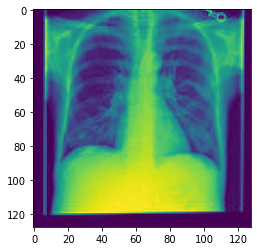

In [16]:
print(toy_train_pa.shape)
plt.imshow(toy_train_pa[0])
plt.show()

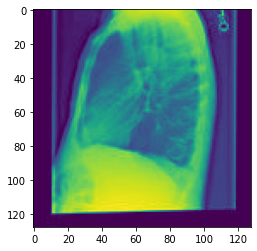

In [17]:
plt.imshow(toy_train_lat[0])
plt.show()

In [21]:
train_labels = pd.read_csv(os.path.join(dir_dataset, 'train_labels.csv')).columns
print(train_labels)

Index(['Unnamed: 0', 'Atelectasis', 'Cardiomegaly', 'Lung Opacity',
       'Pleural Effusion', 'Support Devices', 'No Finding'],
      dtype='object')


In [18]:
str_labels = ['Lung Opacity', 'Pleural Effusion', 'Support Devices']

train_labels = pd.read_csv(os.path.join(dir_dataset, 'train_labels.csv'))[str_labels].fillna(0)
train_labels.head()

,Lung Opacity,Pleural Effusion,Support Devices
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


The labels have 3 classes. Since we use linear classifiers for the evaluation, we remove the 3rd class "unsure" with label -1.
We need to filter out all values where the label is -1 in the dataset.

In [6]:
print(np.unique(train_labels[str_labels].values.ravel(), return_counts=True))
indices = []
indices += train_labels.index[(train_labels['Lung Opacity'] == -1)].tolist()
indices += train_labels.index[(train_labels['Pleural Effusion'] == -1)].tolist()
indices += train_labels.index[(train_labels['Support Devices'] == -1)].tolist()
indices = list(set(indices))
print(train_labels.iloc[indices].head())

(array([-1.,  0.,  1.]), array([  1317, 172334,  11590]))
       Lung Opacity  Pleural Effusion  Support Devices
24581          -1.0               1.0              0.0
16393           1.0              -1.0              0.0
16394           1.0              -1.0              0.0
57373           0.0              -1.0              0.0
8230            0.0              -1.0              0.0


In [7]:
print(len(train_labels), len(indices))
new_train_labels= train_labels.drop(indices)
new_train_labels.head()
print(len(new_train_labels))

61747 1286
60461


## Some of the latent representations are always nans during the basic routine epoch

In [15]:
table = pd.read_csv(os.path.expanduser('~/Documents/master3/leomed_scratch/bugs/basic_routine_epoch.csv'))
for run, subtable in table.groupby('run'):
    print(len(subtable))
    print(pd.DataFrame(subtable.isna().mean().round(4) * 100, columns=['percentage_of_nans']))
    print('\n')

64
                percentage_of_nans
Lateral0_batch                0.00
Lateral0_mean                95.31
Lateral1_batch                0.00
Lateral1_mean                95.31
PA0_batch                     0.00
PA0_mean                     96.88
PA1_batch                     0.00
PA1_mean                     96.88
run                           0.00
text0_batch                   0.00
text0_mean                   95.31
text1_batch                   0.00
text1_mean                   95.31


49
                percentage_of_nans
Lateral0_batch                0.00
Lateral0_mean                95.92
Lateral1_batch                0.00
Lateral1_mean                95.92
PA0_batch                     0.00
PA0_mean                     95.92
PA1_batch                     0.00
PA1_mean                     95.92
run                           0.00
text0_batch                   0.00
text0_mean                   93.88
text1_batch                   0.00
text1_mean                   93.88


36
       

Evaluate length of the sentences

In [5]:
dir_sentences = Path(dir_dataset) / 'oc:3_msl:1024/mimic.train.s1024'
with open(dir_sentences, 'rb') as file:
            data = json.load(file)

In [6]:
sent_lengths = [data[i]['length'] for i in data]

In [8]:
from matplotlib import pyplot as plt

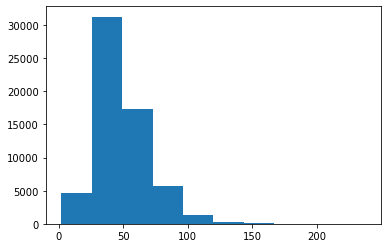

In [9]:
plt.hist(sent_lengths)
plt.show()